# 3'READS+ Pipeline (Part 2)
**This notebook is the Part 2 of the 3'READS+ pipeline, which will do the following:**

1. Register settings for this analysis. One experiment can be analysed with different settings. The results for each setting will be saved in different folders in the *result_dir* directory. 
2. Extend annotated 3'UTR regions to allow identification of new pA sites in previously poorly annotated 3'UTRs. 
3. Assign pA clusters identified in Part 1 to genomic features such as extended 3'UTRs, introns, CDSs, and 5'UTRs.
4. Resolve pA sites mapped to multiple genes.
5. Map intergenic and intronic pA sites to Non-Coding RNAs (ncRNAs).
6. Map intergenic pA sites to Upstream Antisense RNAs (uaRNAs).
7. Map intergenic pA sites to mitochondria.
8. Optionally resolve pA sites mapped to multiple genomic features of the same gene.
9. Plot distribution of pA sites and PASS reads in different genomic features of each sample.
10. Calculate optimal Transcript Starting Sites (TSSs).

Most of the above computation intensive steps are done by **parallel computing**.

**Required softwares**
 * Jupyter Lab
 * R packages: foreach, doParallel, ShortRead, Biostrings, dplyr, tidyr, grid, ggplot2, plotly, etc
 * Linux environment
 
**Hardware requirements**
 * Muticore CPU for parallel computing

## 1. Set configurations specific to this project, experiment, and analysis
These parameters need to be specified for different projects and experiments. One experiment can be analysed with different settings. However, *SHARED_DATA_DIR* is a directory containing frequently used data, such as annotation databases.

In [3]:
SHARED_DATA_DIR = '/home/dinghai/projects/fud'

SETTING = 'NC' # Each data set can be analyzed with different parameter settings

In [4]:
if(SETTING == 'NC'){
  # Which genome was used for mapping?  
  GENOME = 'mm9' # Genome name, currently either mm9 or hg19
  # Define which sample conditions to focus on
  # As mentioned in Part-1 of the pipeline, sample names should be in the format of 
  # "Treatment_Fraction_Batch", such as in "NT_C_1" and "NT_N_1".
  treatments = c("NT") # Order matters. Earlier ones will be reference
  fractions = c("C", "N") # Order matters. Earlier ones will be reference 
  comparisons = c("N_C") # Comparisons to make: N vs C
    
  # Use unique PASS reads for analysis?
  uPASS = F 
  if(uPASS){
    cluster_file = paste0('../results/clusters.using.unique.reads.csv')
    cluster_min_count = 2
  }else{
    cluster_file = paste0('../results/clusters.using.all.reads.csv')
    cluster_min_count = 5
  }
    
  # Settings for filtering low expression pAs 
  lowest_usage = 0 # 5% 
  lowest_rpm = 0 # 1
  lowest_count = 5
  filter_strength = 1 # Fraction of samples satisfying the filters
    
  # When a pA site map to mutlple genomic features of the same gene due to alternative splicing,
  # should we simplify the "region" annotation? 
  simplify_region_annotation = T
  
  # Settings for identifying aUTRs
  neighbor = F # Calculate aUTRs for each neighboring isoforms?
  toptwo = T # Pick top two isoforms for each gene?
  
  # Number of CPUs for parallel computing 
  MAX_WORKERS = 8  
}

In [5]:
result_dir = paste0("../results/", SETTING)
system(paste0("mkdir ", result_dir))
cat("Analysis results will be saved in the following directory:", result_dir) 

Analysis results will be saved in the following directory: ../results/NC

Load packages:

In [6]:
require(tidyr)
require(magrittr)
require(dplyr)
require(ggplot2)
require(plotly)
require(gplots)
require(GenomicFeatures)
require(docstring)
require(foreach)
require(doParallel)
registerDoParallel(MAX_WORKERS)
theme_set(theme_bw(base_size = 15) + theme(plot.title = element_text(hjust = 0.5)))

# Depending on the genome, load the right packages:
if(GENOME == "mm9"){
  require("org.Mm.eg.db")
  org.db = org.Mm.eg.db
  txdb_path = file.path(SHARED_DATA_DIR, "mm9.refGene.txdb.sqlite")
  BSspec = "Mmusculus"
}else if(GENOME == "hg19"){
  require("org.Hs.eg.db")
  org.db = org.Hs.eg.db
  txdb_path = file.path(SHARED_DATA_DIR, "hg19.refGene.txdb.sqlite")
  BSspec = "Hsapiens"
}
    
BSgeno = paste0("BSgenome.", BSspec, ".UCSC.", GENOME)
require(BSgeno, character.only = T) 

Loading required package: tidyr
Loading required package: magrittr

Attaching package: ‘magrittr’

The following object is masked from ‘package:tidyr’:

    extract

Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: ggplot2
Loading required package: plotly

Attaching package: ‘plotly’

The following object is masked from ‘package:ggplot2’:

    last_plot

The following object is masked from ‘package:stats’:

    filter

The following object is masked from ‘package:graphics’:

    layout

Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess

Loading required package: GenomicFeatures
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following object

If the txDb has not been downloaded yet, download it and save it to the shared data directory:

In [7]:
tryCatch(
  {txdb = loadDb(txdb_path)},
  error = function(e){
    txdb = makeTxDbFromUCSC(genome = GENOME, tablename = 'refGene')
    saveDb(txdb, file.path(SHARED_DATA_DIRD, paste0(GENOME, ".refGene.txdb.sqlite")))
  }
)

## 2. Extend annotated 3'UTR regions to allow identification of new pA sites in poorly annotated 3'UTRs. 

First, define a helper function that will be reused several times later. The first line is a DocString.

In [8]:
rename_grl = function(grl, old_key = "ACCNUM", new_key = "SYMBOL"){
    #' A function to rename GRanges in a GRangeList.
    
    # Convert a GRangeList to a GRanges for faster calculation
    gr = unlist(grl)

    # Convert the accession numbers of the genes into gene symbols
    names(gr) = mapIds(org.db, keys = names(gr), keytype = old_key, column = new_key)
    
    # Rebuild 3'UTRs by gene symbol 
    grl = split(gr, names(gr))   

    # Collapse features
    grl = reduce(grl)
}

To extend 3'UTRs, I first get 4 kb regions downstream of annotated 3'UTRs. If the downstream regions overlap with downstream genes, I'll shrink the downstream regions to avoid overlaps. On the other hand, if the beginnings of the downstream regions are located within any genes (e.g. intronic 3'UTRs), I will undo the extension by setting the start and end of the extension to be identical. Downstream regions are processed separately for 3'UTRs on the plus and minus strands. Finally, the 3'UTRs and downstream regions are combined to get extended 3'UTRs. Please note that the extended 3'UTRs are just candidate 3'UTR regions. The exact 3'UTR boundaries will be determined by pA sites that can be mapped to them.

In [9]:
# Get 3'UTR annotation from Refseq
threeUTRs = threeUTRsByTranscript(txdb, use.names=T)

# Rename the 3'URs with gene symbols
threeUTRs = rename_grl(threeUTRs, old_key = "ACCNUM", new_key = "SYMBOL")

# Convert to GRanges for later use
utr3 = unlist(threeUTRs)

# Get 4 kb downstream regions. 3'UTR regions not included
# Out of boundary regions need to be trimmed
ds = trim(flank(utr3, 4000, start=F))

# Get GRanges for genes
genes = genes(txdb, filter=NULL, single.strand.genes.only=T)
 
# Find extensions that overlap with genes on positive strands:
olp = findOverlaps(ds[strand(ds) == "+"], genes[strand(genes) == "+"])

# Which 3'UTRs have been extended too far?
extended_into_genes = start(ds[strand(ds) == "+"][queryHits(olp)]) < 
                      start(genes[strand(genes) == "+"][subjectHits(olp)])

# Reset the extended region so that the extended region no longer overlap with genes
end(ds[strand(ds) == "+"][queryHits(olp)][extended_into_genes]) =
    start(genes[strand(genes) == "+"][subjectHits(olp)][extended_into_genes]) - 1 

# If the bebinning of 3'UTR downstream region is located within any genes, don't extend either.
width(ds[strand(ds) == "+"][queryHits(olp)][!extended_into_genes]) = 1 

# Find extensions that overlap with genes on negative strands:
olp = findOverlaps(ds[strand(ds) == "-"], genes[strand(genes) == "-"])

# Which 3'UTRs have been extended too far?
extended_into_genes = end(ds[strand(ds) == "-"][queryHits(olp)]) > 
                      end(genes[strand(genes) == "-"][subjectHits(olp)])

# Reset the extended region so that the extended region no longer overlap with genes
start(ds[strand(ds) == "-"][queryHits(olp)][extended_into_genes]) = 
    end(genes[strand(genes) == "-"][subjectHits(olp)][extended_into_genes]) + 1 

# If the bebinning of 3'UTR downstream region is located within any genes, don't extend either.
end(ds[strand(ds) == "-"][queryHits(olp)][!extended_into_genes]) = 
    start(ds[strand(ds) == "-"][queryHits(olp)][!extended_into_genes]) 

# Combind previous 3'UTR definition with the downstream region to define extended 3'UTRs
utr3 = resize(utr3, width = width(utr3) + width(ds)-1, fix="start")

# Rebuild 3'UTRs named by gene symbol 
threeUTRs = split(utr3, names(utr3))

Warning message in .set_group_names(ans, use.names, txdb, "tx"):
“some group names are NAs or duplicated”'select()' returned 1:1 mapping between keys and columns
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 4 out-of-bound ranges located on sequences
  chrUn_random, chr12, chr13, and chr3. Note that ranges located on a
  sequence whose length is unknown (NA) or on a circular sequence are not
  considered out-of-bound (use seqlengths() and isCircular() to get the
  lengths and circularity flags of the underlying sequences). You can use
  trim() to trim these ranges. See ?`trim,GenomicRanges-method` for more
  information.”

## 3.1. Read the pA cluster file created in Part-1 of the pipeline and create a GRange:

In [10]:
# Calculate sample names and batch numbers
header = strsplit(readLines(cluster_file, n = 1), ",")[[1]]

sample_names = grep(paste0("(", paste0(treatments, collapse="|"), 
                           ")_(", paste0(fractions,collapse="|"), 
                           ")_\\d+"), 
                    header[-c(1:3)], value = T)

batches = unique(sub(".+_(\\d+.?)$", "\\1", sample_names)) 

cat(paste0("The following samples will be used for the analysis named '", SETTING, "':")) 
sample_names

The following samples will be used for the analysis named 'NC':

[1] "NT_C_1" "NT_C_2" "NT_C_3" "NT_N_1" "NT_N_2" "NT_N_3"

In [11]:
# Only read desirable columns of the cluster file
cluster = read.csv(cluster_file)[, c("chromosome","strand","position", sample_names)]

# Require at least cluster_min_count reads for more than 2 samples
cluster = subset(cluster, rowSums(cluster[,-c(1:3)] >= cluster_min_count) >= 2)

# Create a GRanges object
pA = GRanges(seqnames = cluster$chromosome, strand = cluster$strand,
             ranges = IRanges(start = cluster$position, end = cluster$position))

mcols(pA, use.names = T) = cluster[,-c(1:3)]

rm(cluster)

## 3.2. Map the pA sites to extended 3'UTRs

In [12]:
pA$gene_symbol = ""
pA$region = ""
olp = findOverlaps(pA, threeUTRs)
pA[queryHits(olp), ]$gene_symbol = names(threeUTRs[subjectHits(olp)])
pA[queryHits(olp), ]$region = "3UTR"

## 3.3. Map the pA sites to introns

In [13]:
# Get intron annotation
introns = intronsByTranscript(txdb, use.names=T)

# Use the previously defined helper function to rename introns
introns = rename_grl(introns, old_key = "ACCNUM", new_key = "SYMBOL")

# Which clusters are mapped to which introns?
olp = findOverlaps(pA, introns)

# Some "intronic" pA sites have never been considered as 3'UTR pA sites 
index1 = which(pA[queryHits(olp), ]$gene_symbol == "")
pA[queryHits(olp), ][index1, ]$gene_symbol = names(introns[subjectHits(olp[index1,])])
pA[queryHits(olp), ][index1, ]$region = "intron"

# Some "intronic" pA sites have already been considered as 3'UTR pA sites 
index2 = which(pA[queryHits(olp), ]$gene_symbol != "")
pA[queryHits(olp), ][index2, ]$gene_symbol = paste0(pA[queryHits(olp), ][index2, ]$gene_symbol, 
                                                    "|", 
                                                    names(introns[subjectHits(olp[index2,])]))
pA[queryHits(olp), ][index2, ]$region = paste0(pA[queryHits(olp), ][index2, ]$region, "|intron")

Warning message in .set_group_names(ans, use.names, x, "tx"):
“some group names are NAs or duplicated”'select()' returned 1:1 mapping between keys and columns


## 3.4. Map the pA sites to CDS

In [14]:
# Get CDS annotation
cds = cdsBy(txdb, by="tx", use.names=T)

# Use the previously defined helper function to rename CDS
cds = rename_grl(cds, old_key = "ACCNUM", new_key = "SYMBOL")

# Which clusters are mapped to which cds?
olp = findOverlaps(pA, cds)

# Some "CDS" pAs have never been considered as other featuers
index1 = which(pA[queryHits(olp), ]$gene_symbol == "")
if(length(index1) > 0){
  pA[queryHits(olp), ][index1, ]$gene_symbol = names(cds[subjectHits(olp[index1,])])
  pA[queryHits(olp), ][index1, ]$region = "CDS"
  }

# Some "CDS" have already been considered as other featuers
index2 = which(pA[queryHits(olp), ]$gene_symbol != "")
if(length(index2) > 0){
  pA[queryHits(olp), ][index2, ]$gene_symbol = 
    paste0(pA[queryHits(olp), ][index2, ]$gene_symbol, "|", 
           names(cds[subjectHits(olp[index2,])]))
  pA[queryHits(olp), ][index2, ]$region = paste0(pA[queryHits(olp), ][index2, ]$region, "|CDS")
  }

Warning message in .set_group_names(grl, use.names, txdb, by):
“some group names are NAs or duplicated”'select()' returned 1:1 mapping between keys and columns


## 3.5. Map the pA sites to 5'UTRs

In [15]:
# Get 5'UTR annotation
fiveUTRs = fiveUTRsByTranscript(txdb, use.names=T) 

# Use the previously defined helper function to rename CDS
fiveUTRs = rename_grl(fiveUTRs, old_key = "ACCNUM", new_key = "SYMBOL")

# Which clusters are mapped to which 5'UTRs?
olp = findOverlaps(pA, fiveUTRs)

# Some 5'UTR pA sites have never been considered as other featuers
index1 = which(pA[queryHits(olp), ]$gene_symbol == "")
if(length(index1) > 0){
  pA[queryHits(olp), ][index1, ]$region = "5UTR"
  pA[queryHits(olp), ][index1, ]$gene_symbol = names(fiveUTRs[subjectHits(olp[index1,])])
  }

# Some 5'UTRs have already been considered as other featuers
index2 = which(pA[queryHits(olp), ]$gene_symbol != "")
if(length(index2) > 0){
  pA[queryHits(olp), ][index2, ]$region = paste0(pA[queryHits(olp), ][index2, ]$region, "|5UTR")
  pA[queryHits(olp), ][index2, ]$gene_symbol = 
    paste0(pA[queryHits(olp), ][index2, ]$gene_symbol, "|", 
           names(fiveUTRs[subjectHits(olp[index2,])]))
  }

pA[pA$region == ""]$region = "intergenic"

Warning message in .set_group_names(ans, use.names, txdb, "tx"):
“some group names are NAs or duplicated”'select()' returned 1:1 mapping between keys and columns


## 4. Resolve pA sites mapped to multiple genes.
Some pA sites are mapped to multiple genes. The conflict will be resolved based on the priority of 3UTR > intron > CDS.

In [16]:
# Resolve pAs mapped to multiple genes
index1 = which(sapply(strsplit(pA$gene_symbol, "\\|"), function(x) length(unique(x))) > 1)
                      
# If the first region annotation is 3UTR, then only keep the first gene_symbol 
if(length(index1) > 0){
  index2 = grepl("^3UTR", pA[index1,]$region)
  pA[index1,][index2,]$gene_symbol = sub("\\|.+$", "", pA[index1,][index2,]$gene_symbol)
  pA[index1,][index2,]$region = "3UTR"
}
                      
# Next, if the first region annotation is intron, then only keep the first gene_symbol 
index1 = which(sapply(strsplit(pA$gene_symbol, "\\|"), function(x) length(unique(x))) > 1)
if(length(index1) > 0){
  index2 = grepl("^intron", pA[index1,]$region)
  pA[index1,][index2,]$gene_symbol = sub("\\|.+$", "", pA[index1,][index2,]$gene_symbol)
  pA[index1,][index2,]$region = "intron"
}

# Next, if the first region annotation is CDS, then only keep the first gene_symbol
index1 = which(sapply(strsplit(pA$gene_symbol, "\\|"), function(x) length(unique(x))) > 1)
if(length(index1) > 0){
  index2 = grepl("^CDS", pA[index1,]$region)
  pA[index1,][index2,]$gene_symbol = sub("\\|.+$", "", pA[index1,][index2,]$gene_symbol)
  pA[index1,][index2,]$region = "CDS"
}
                      
# Delete other pAs that can be mapped to >1 gene
index1 = which(sapply(strsplit(pA$gene_symbol, "\\|"), function(x) length(unique(x))) > 1)
if (length(index1) > 0){
  pA = pA[-index1,]
}
                      
# Now simplify gene_symbol for all genes
pA$gene_symbol = sub("\\|.+$", "", pA$gene_symbol)
pA$gene_symbol[pA$gene_symbol == ""] = "Unknown"

## 5. Map intergenic and intronic pA sites to Non-Coding RNAs (ncRNAs)
Non-coding RNAs can be extracted from UCSC refGene table by requiring that *cdsStart* equals *cdsEnd*. 

In [17]:
# Get noncoding RNA annotation
con = src_mysql(dbname = GENOME, 
                user = "genome", 
                password = "", 
                host = "genome-mysql.cse.ucsc.edu")

ncTx = con %>%
  tbl("refGene") %>%
  # select(name,chrom,strand,cdsStart,cdsEnd, txStart, txEnd) %>% 
  filter(cdsStart==cdsEnd) %>%
  distinct() %>%
  collect()

# Convert to GRanges
ncTx = split(as.data.frame(ncTx), ncTx$name)

# A helper function to process CDS of transcripts in multiple exons
process_multi_exons = function(df){
  if(length(df$name) == 1){
    starts = as.numeric(strsplit(df$exonStarts, ",")[[1]])
    ends = as.numeric(strsplit(df$exonEnds, ",")[[1]])
    gr = GRanges(seqnames = df$chrom, strand = df$strand, 
                 ranges = IRanges(start=starts, end=ends))
    gr$gene_symbol = df$name
    gr
  }
}
ncTx = lapply(ncTx, process_multi_exons)
ncTx = GRangesList(ncTx[sapply(ncTx, class) == "GRanges"])

# Map pAs in intergernic or intronic region to ncRNAs
olp = findOverlaps(pA[grepl("intergenic|^intron", pA$region)], ncTx) 
                   
# Discard pAs mapped to multiple ncRNAs
olp = olp[!duplicated(queryHits(olp))]
                   
# Remove gene symbol of the host genes
pA[grepl("intergenic|^intron", pA$region)][queryHits(olp), ]$gene_symbol = 
                                              names(ncTx)[subjectHits(olp)]
                   
# Update region annotation
pA[grepl("intergenic|^intron", pA$region)][queryHits(olp), ]$region = "ncRNA"

Warning message in .local(conn, statement, ...):
“Unsigned INTEGER in col 0 imported as numeric”Warning message in .local(conn, statement, ...):
“Unsigned INTEGER in col 4 imported as numeric”Warning message in .local(conn, statement, ...):
“Unsigned INTEGER in col 5 imported as numeric”Warning message in .local(conn, statement, ...):
“Unsigned INTEGER in col 6 imported as numeric”Warning message in .local(conn, statement, ...):
“Unsigned INTEGER in col 7 imported as numeric”Warning message in .local(conn, statement, ...):
“Unsigned INTEGER in col 8 imported as numeric”Warning message in .local(conn, statement, ...):
“Unsigned INTEGER in col 0 imported as numeric”Warning message in .local(conn, statement, ...):
“Unsigned INTEGER in col 4 imported as numeric”Warning message in .local(conn, statement, ...):
“Unsigned INTEGER in col 5 imported as numeric”Warning message in .local(conn, statement, ...):
“Unsigned INTEGER in col 6 imported as numeric”Warning message in .local(conn, statemen

## 6. Map pA sites to Upstream Antisense RNAs (uaRNAs)
Transcription in sense direction produces mRNA, while upstream antisense transcription generates non-coding transcripts called uaRNA (upstream antisense RNA). I'll define the antisense 4000 kb region as candidate UA regions.

In [18]:
# Define UA (upstream antisense) regions
ua = promoters(txdb, upstream=4000, downstream=0) # returns 1 record per transcript 

# Reverse the strand to get antisense region
strand(ua) = Rle(as.factor(ifelse(strand(ua) == "+", "-", "+")))

# Convert the accession numbers of the genes into gene symbols
names(ua) = mapIds(org.db, keys = ua$tx_name, keytype =  "ACCNUM", column =  "SYMBOL")

ua = split(ua, names(ua))

'select()' returned 1:1 mapping between keys and columns


Map pA sites that have never been annotated to UA regions.

In [19]:
# Which clusters are mapped to which ua?
olp = findOverlaps(pA, ua)

# Which pAs have never been considered as other featuers?
index1 = which(pA[queryHits(olp), ]$gene_symbol == "Unknown") 

# Only update pAs that have never been considered as other featuers
if(length(index1)){
  pA[queryHits(olp), ][index1, ]$gene_symbol = names(ua[subjectHits(olp[index1,])])
  pA[queryHits(olp), ][index1, ]$region = "UA"
}

## 7. Plot the fractions of intergenic pAs mapped to the mitochondria genome

In [26]:
# Count chrM reads
chrM_counts = colSums(data.frame(mcols(pA)[seqnames(pA)=="chrM",])[,sample_names])
total_counts = colSums(data.frame(mcols(pA))[,sample_names])

df = data.frame(chrM_counts, total_counts, sample_names) %>%
     mutate(chrM_fraction = chrM_counts/total_counts) %>%
     mutate(group = sub("(.+)_\\d.*$", "\\1", sample_names)) %>%
     arrange(sample_names)

p = ggplot(df, aes(x = sample_names, y = chrM_fraction, fill = group)) +
    geom_col() +
    scale_fill_hue() +
    coord_flip() +
    xlab("Sample Names") +
    ylab("Fraction of chrM PASS reads")

png(file.path(result_dir, "chrM_PASS_reads_fraction.png"), 100*nrow(df), 500)
print(p)
dev.off()

png 
  2

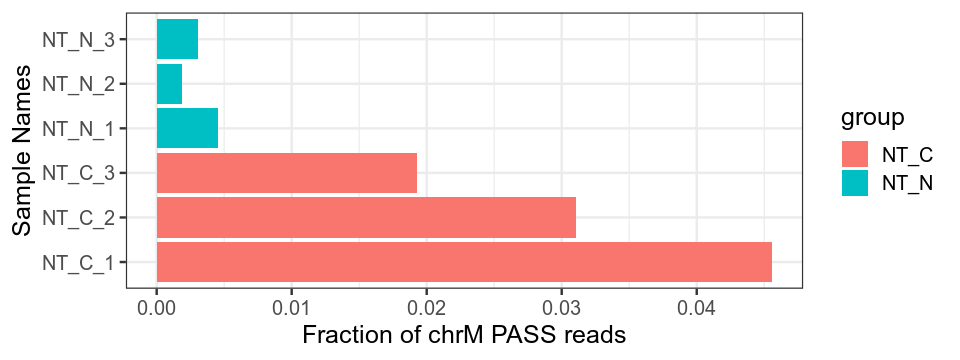

In [27]:
# Change plot size 
library(repr)
options(repr.plot.width=8, repr.plot.height=3)

p

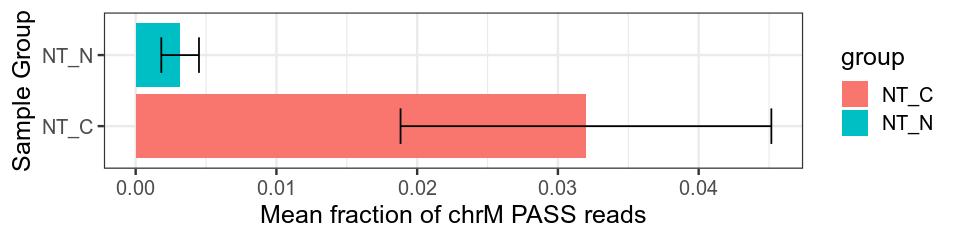

In [28]:
# Calculate mean and sd of chrM fractions
if(length(batches) > 1){
#  df$sample_names = sub(paste0("_(", paste(batches, collapse = "|"), ")"), "", df$sample_names)
  df = df %>%
    group_by(group) %>%
    summarise(chrM_mean_fraction = mean(chrM_fraction), chrM_fraction_sd = sd(chrM_fraction)) 
  
  p = ggplot(df, aes(x = group, y=chrM_mean_fraction, fill = group)) +
    geom_col() +
    geom_errorbar(aes(x = group, 
                      ymin = chrM_mean_fraction-chrM_fraction_sd, 
                      ymax = chrM_mean_fraction+chrM_fraction_sd), 
                  width = 0.5) + 
    coord_flip() +
    xlab("Sample Group") +
    ylab("Mean fraction of chrM PASS reads")
  
  png(file.path(result_dir, "mean_chrM_reads_fraction.png"), 100*nrow(df), 500)
  print(p)
    
  
  options(repr.plot.width=8, repr.plot.height=2)
  dev.off()
  p
}

Set the "region" of intergenic pAs mapped to the mitochondria genome to "chrM":

In [29]:
pA[pA$region == "intergenic" & seqnames(pA) == "chrM"]$region = "chrM"

## 8. Optionally resolve pA sites mapped to multiple genomic features of the same gene
pA sites can be mapped to multiple genomic features of the same gene due to alternative splicing. By default, the region annotation is simplified unless specified otherwise.

In [30]:
# Fix pAs mapped to multiple features
if(!exists("simplify_region_annotation") || simplify_region_annotation){
  pA$region[grepl("\\|intron$", pA$region)] = "intron"
  pA$region[grepl("\\|CDS$", pA$region)] = "CDS"
  pA$region[grepl("\\|5UTR$", pA$region)] = "5UTR"
}

## 9. Plot summarised distribution of pA sites and reads in genomic features in each sample.
First, summarize pA sites and read numbers in each genomic features in each sample. pA sites with less than *min_count_* in the sample are omitted. The results are saved in an Excel file.

In [31]:
require(scales)
require(openxlsx)

min_count_ = 5 # Read count filter

df = mcols(pA)[, c("region", sample_names)]

# Collapse pAs mapped to multiple features
df$region[grepl("\\|intron$", df$region)] = "intron"
df$region[grepl("\\|CDS$", df$region)] = "CDS"
df$region[grepl("\\|5UTR$", df$region)] = "5UTR"

# Change region names so that they can be used as column names
df$region[df$region == "3UTR"] = "UTR3"
df$region[df$region == "5UTR"] = "UTR5"


# Initialize counting matrixes
region_summary = matrix(nrow = 0, ncol = length(names(table(df$region))))
colnames(region_summary) = names(table(df$region))

read_summary = matrix(ncol = 0, nrow = length(names(table(df$region))))
rownames(read_summary) = names(table(df$region))


# Go through each sample, filter out pAs with low read numbers, and summarize
for(sample_name in sample_names){
  df_ = df[, c("region", sample_name)]
  df_ = df_[df_[, sample_name] >= min_count_, ]
  
  # Summarize numbers of pA site
  region_summary = rbind(region_summary, table(df_$region))
  
  # Summarize read numbers 
  col = group_by(as.data.frame(df_), region) %>%
    summarize_at(vars(sample_name), sum)
  read_summary = cbind(read_summary, col[, sample_name])
  
}

# Add row names and reorder rows
rownames(region_summary) = sample_names
region_summary = region_summary[order(rownames(region_summary)),]
region_summary = t(region_summary)

# Write to Excel
wb = createWorkbook()
addWorksheet(wb, "pA_region_summary")
writeData(wb, sheet = 1, region_summary, rowNames = T)
addWorksheet(wb, "pA_read_summary")
writeData(wb, sheet = 2, read_summary, rowNames = T)
saveWorkbook(wb, file.path(result_dir, "pA_region_and_read_summary.xlsx"), overwrite = TRUE)

Loading required package: scales
Loading required package: openxlsx
Note: zip::zip() is deprecated, please use zip::zipr() instead


Plot distribution of pA sites. The ggplotly() function from the plotly library converts static ggplot2 figures into interactive figures.

In [32]:
# Plotting
region_summary = as.data.frame(region_summary)
region_summary$region = rownames(region_summary)
region_summary = gather(region_summary, key=Sample, value=num_pA, -region)
region_summary$region = factor(region_summary$region, 
                               levels = c("intergenic", "chrM", "ncRNA", "UA", 
                                          "UTR5", "CDS", "intron", "UTR3"))

p = ggplot(data=region_summary, aes(x=Sample, y=num_pA, fill = region)) + 
  geom_col(position = "fill") + 
  scale_y_continuous(labels = percent_format()) +
  ylab("Percentage of pA sites") +
  coord_flip()

png(file.path(result_dir, "num_pA_summary.png"), 800, length(sample_names)*50)
print(p)
dev.off()

# ggplotly(p) # Uncomment this if you want to see interactive plots.

png 
  2

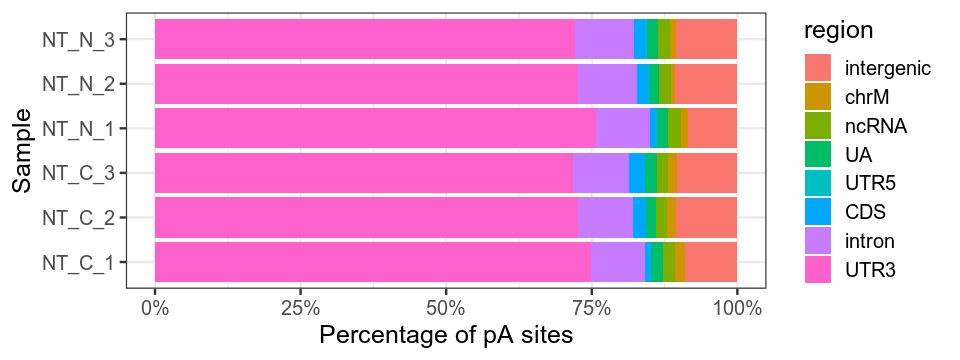

In [33]:
# Change plot size 
library(repr)
options(repr.plot.width=8, repr.plot.height=3)
p

Plot distribution of PASS reads. The ggplotly() function from the plotly library converts static ggplot2 figures into interactive figures.

In [34]:
read_summary = as.data.frame(read_summary)
read_summary$region = rownames(read_summary)
read_summary = gather(read_summary, key=Sample, value=num_read, -region)
read_summary$region = factor(read_summary$region, 
                             levels = c("intergenic", "chrM", "ncRNA", "UA",
                                        "UTR5", "CDS", "intron", "UTR3"))

p = ggplot(data=read_summary, aes(x=Sample, y=num_read, fill = region)) + 
  geom_col(position = "fill") + 
  scale_y_continuous(labels = percent_format()) +
  ylab("Percentage of PASS reads") +
  coord_flip()

png(file.path(result_dir, "num_read_summary.png"), 800, length(sample_names)*50)
print(p)
dev.off()

# ggplotly(p) # Uncomment this if you want to see interactive plots.

png 
  2

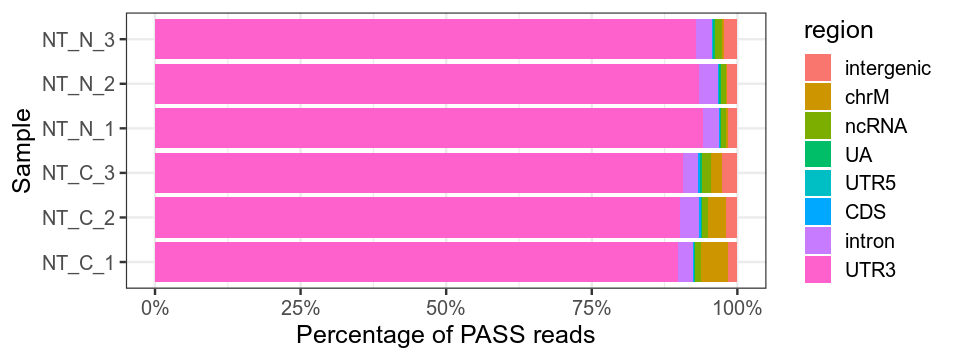

In [35]:
p

# 10. Calculate transcript starting sites (TSSs) 
If >1 UA pA sites and >1 TSSs exist, use the TSS closest to the most downstream UA pA site, otherwise only keep the most upstream TSS.

In [36]:
# Get TSS 
tss = promoters(txdb, upstream=0, downstream=1, columns=c("tx_name", "gene_id"))

# Convert the accession numbers of the genes into gene symbols
tss$gene_symbol = mapIds(org.db, keys = as.character(tss$tx_name),
                         keytype =  "ACCNUM", column =  "SYMBOL")

# Only consider detected genes
tss = tss[tss$gene_symbol %in% pA$gene_symbol]

# Remove duplicates (One gene can have multiple transcripts with the same TSS)
tss = data.frame(chr = seqnames(tss), strand = strand(tss), 
                 position = start(tss), gene_symbol = tss$gene_symbol)
tss = unique(tss)
tss$gene_symbol = as.vector(tss$gene_symbol)

# Calculate signed position for later use 
pA$signed_position = start(pA) * ifelse(strand(pA) == "+", 1, -1)
tss$signed_position = tss$position * ifelse(tss$strand == "+", 1, -1) 

# Split tss into two categories and treat them differently
tss_with_ua = tss[tss$gene_symbol %in% pA[pA$region == "UA"]$gene_symbol, ]
tss_without_ua = tss[!tss$gene_symbol %in% pA[pA$region == "UA"]$gene_symbol, ]

# Loop through genes in tss_with_ua, select the most reasonable TSS for each gene
tss_with_ua_new = data.frame()
for(gene in unique(tss_with_ua$gene_symbol)){
  tss_for_gene = subset(tss_with_ua, gene_symbol == gene)
  if(nrow(tss_for_gene) == 1){
    tss_with_ua_new = rbind(tss_with_ua_new, tss_for_gene)
  }else{
    # Determine the most reasonable UA pA sites: 
    # pick the UA pA sites upstream to all other UA pA sites
    ua_pA = pA[pA$gene_symbol == gene & pA$region == "UA"] # may have >1 rows
    # ua_pA$signed_position is negative if the gene is on positive strand!
    ua_pA = ua_pA[order(ua_pA$signed_position), ][1,] 
    # tss must be down stream of UA pA site 
    tss_for_gene = tss_for_gene[-ua_pA$signed_position - tss_for_gene$signed_position < 0,]
    # Select the tss closest to the UA pA site
    tss_for_gene = tss_for_gene[which.max(-ua_pA$signed_position - 
                                          tss_for_gene$signed_position),]
    tss_with_ua_new = rbind(tss_with_ua_new, tss_for_gene)
  }
}

# For tss without detected ua pA sites, simply pick the most upstream one
tss_without_ua = tss_without_ua[order(tss_without_ua$gene_symbol, 
                                      tss_without_ua$signed_position), ]
tss_without_ua = split(tss_without_ua, f=tss_without_ua$gene_symbol)
tss_without_ua = do.call(rbind, lapply(tss_without_ua, function(x) x[1,]))
                                       
# Combine the two data frame
tss = rbind(tss_with_ua_new, tss_without_ua)
df = data.frame(gene_symbol = as.vector(pA$gene_symbol))
                                       
# Unmatched rows will be put at the end of the merged table
df = merge(df, tss, by = "gene_symbol", all.x=T, sort=F)
                                       
# Cannot assume that the order remain the same even after setting sort = F
pA = pA[order(pA$gene_symbol)] 
df = df[order(df$gene_symbol),]
pA$tss_position = df$position

rm(tss)
rm(df)

'select()' returned 1:1 mapping between keys and columns


This is the end of Part-2 of the pipeline. The *pA* object can be saved for further analysis.

In [37]:
saveRDS(pA, file = file.path(result_dir, "pA.rds"))

## 11.1. Calculate CDS features for the transcript with longest CDS of each gene

In [38]:
# Calculate CDS features of the transcript with maximum CDS length for each gene
cds = cdsBy(txdb, by="tx", use.names=T) 

# Calculate total CDS length for each transcript
cds_length = foreach(i=1:length(cds), .combine = "c") %dopar%{
  sum(width(cds[i]))
}

# Split by gene symbols
cds_length = split(cds_length, mapIds(org.db, keys = names(cds_length), 
                                      keytype =  "ACCNUM", column =  "SYMBOL"))

# Get transcripts with longest CDS
max_cds_tx_name = names(sapply(cds_length, which.max))
max_cds_tx_name = sub("^.+\\.", "", max_cds_tx_name) 

# Get CDS sequence
maxCDS_seq = getSeq(eval(parse(text = BSspec)), cds[max_cds_tx_name])
maxCDS_seq = lapply(maxCDS_seq, function(x) unlist(x))
maxCDS_seq = DNAStringSet(maxCDS_seq)
                    
# Calculate base frequency
base_fraction = alphabetFrequency(maxCDS_seq, baseOnly=T, as.prob=T)
                    
CDS_features = data.frame(maxCDS_tx= names(maxCDS_seq), 
                          cds_start = unlist(start(range(cds[max_cds_tx_name]))),
                          cds_end = unlist(end(range(cds[max_cds_tx_name]))),
                          CDS_size = width(maxCDS_seq), 
                          CDS_GC = base_fraction[, "C"] + base_fraction[, "G"])
                    
CDS_features$maxCDS_tx = as.character(CDS_features$maxCDS_tx)
                    
CDS_features$gene_symbol =  mapIds(org.db, keys = CDS_features$maxCDS_tx, 
                                   keytype =  "ACCNUM", column =  "SYMBOL")

Warning message in .set_group_names(grl, use.names, txdb, by):
“some group names are NAs or duplicated”'select()' returned 1:1 mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns


## 11.2. Calculate intron features for the transcript with longest CDS of each gene

In [39]:
# Calculate features of introns of the longest CDS transcript
options(echo = F)
options(warn = -1)

introns = intronsByTranscript(txdb, use.names=T)

introns = introns[names(introns) %in% CDS_features$maxCDS_tx]

intron_sizes = lapply(introns, function(intron) width(intron))

intron_features = data.frame(maxCDS_tx = as.character(names(introns)), 
                             max_intron_size = sapply(intron_sizes, max), 
                             min_intron_size = sapply(intron_sizes, min),
                             total_intron_size = sapply(intron_sizes, sum),
                             num_intron = sapply(intron_sizes, 
                                                 function(sizes) sum(sizes > 0)))
                                                 
intron_features[intron_features %in% c(Inf, -Inf)] = 0

## 11.3. Calculate 5'UTR features for the transcript with longest CDS of each gene

In [40]:
# Calculation features of 5'UTRs of the longest CDS transcript
UTR5 = fiveUTRsByTranscript(txdb, use.names=T) 
UTR5 = UTR5[names(UTR5) %in% CDS_features$maxCDS_tx]

UTR5_seq = getSeq(eval(parse(text = BSspec)), UTR5)
UTR5_seq = lapply(UTR5_seq, function(x) unlist(x))
UTR5_seq = DNAStringSet(UTR5_seq)
                  
base_fraction = alphabetFrequency(UTR5_seq, baseOnly=T, as.prob=T)

UTR5_features = data.frame(maxCDS_tx = names(UTR5), 
                           UTR5_size = sapply(UTR5, function(UTR5) sum(width(UTR5))), 
                           UTR5_GC = base_fraction[, "C"] + base_fraction[, "G"])
                           
UTR5_features$maxCDS_tx = as.character(UTR5_features$maxCDS_tx)

In [42]:
findPotentialStartsAndStops <- function(sequence){
  library("Biostrings")
  # Define a vector with the sequences of potential start and stop codons
  codons <- c("ATG", "TAA", "TAG", "TGA")
  sequence = toupper(sequence)
  # Find the number of occurrences of each type of potential start or stop codon
  for(i in 1:4){
    codon <- codons[i]
    # Find all occurrences of codon "codon" in sequence "sequence"
    occurrences <- matchPattern(codon, sequence)
    # Find the start positions of all occurrences of "codon" in sequence "sequence"
    codonpositions <- start(occurrences)
    # Find the total number of potential start and stop codons in sequence "sequence"
    numoccurrences <- length(codonpositions)
    if (i == 1){
      # Make a copy of vector "codonpositions" called "positions"
      positions <- codonpositions
      # Make a vector "types" containing "numoccurrences" copies of "codon"
      types <- rep(codon, numoccurrences)
    }else{
      # Add the vector "codonpositions" to the end of vector "positions":
      positions   <- append(positions, codonpositions, after=length(positions))
      # Add the vector "rep(codon, numoccurrences)" to the end of vector "types":
      types       <- append(types, rep(codon, numoccurrences), after=length(types))
    }
  }
  # Sort the vectors "positions" and "types" in order of position along the input sequence:
  indices <- order(positions)
  positions <- positions[indices]
  types <- types[indices]
  # Return a list variable including vectors "positions" and "types":
  mylist <- list(positions,types)
  return(mylist)
}
# s1 <- "aaaatgcagtaacccatgccc"
# findPotentialStartsAndStops(s1)

In [43]:
findORFsinSeq <- function(sequence){
  require(Biostrings)
  # Make vectors "positions" and "types" containing information on the positions of ATGs in the sequence:
  mylist <- findPotentialStartsAndStops(sequence)
  positions <- mylist[[1]]
  types <- mylist[[2]]
  # Make vectors "orfstarts" and "orfstops" to store the predicted start and stop codons of ORFs
  orfstarts <- numeric()
  orfstops <- numeric()
  # Make a vector "orflengths" to store the lengths of the ORFs
  orflengths <- numeric()
  # Print out the positions of ORFs in the sequence:
  # Find the length of vector "positions"
  numpositions <- length(positions)
  # There must be at least one start codon and one stop codon to have an ORF.
  if (numpositions >= 2){
    for (i in 1:(numpositions-1)){
      posi <- positions[i]
      typei <- types[i]
      found <- 0
      while (found == 0){
        for (j in (i+1):numpositions){
          posj  <- positions[j]
          typej <- types[j]
          posdiff <- posj - posi
          posdiffmod3 <- posdiff %% 3
          # Add in the length of the stop codon
          orflength <- posj - posi + 3
          if (typei == "ATG" && (typej == "TAA" || typej == "TAG" || typej == "TGA") && posdiffmod3 == 0){
            # Check if we have already used the stop codon at posj+2 in an ORF
            numorfs <- length(orfstops)
            usedstop <- -1
            if (numorfs > 0){
              for (k in 1:numorfs){
                orfstopk <- orfstops[k]
                if (orfstopk == (posj + 2)) { usedstop <- 1 }
              }
            }
            if (usedstop == -1){
              orfstarts <- append(orfstarts, posi, after=length(orfstarts))
              orfstops <- append(orfstops, posj+2, after=length(orfstops)) # Including the stop codon.
              orflengths <- append(orflengths, orflength, after=length(orflengths))
            }
            found <- 1
            break
          }
          if (j == numpositions) { found <- 1 }
        }
      }
    }
  }
  # Sort the final ORFs by start position:
  indices <- order(orfstarts)
  orfstarts <- orfstarts[indices]
  orfstops <- orfstops[indices]
  # Find the lengths of the ORFs that we have
  orflengths <- numeric()
  numorfs <- length(orfstarts)
  for (i in 1:numorfs)
  {
    orfstart <- orfstarts[i]
    orfstop <- orfstops[i]
    orflength <- orfstop - orfstart + 1
    orflengths <- append(orflengths,orflength,after=length(orflengths))
  }
  mylist <- list(orfstarts, orfstops, orflengths)
  names(mylist) = c("starts", "ends", "lengths")
  return(mylist)
}
s1 <- "aaaatgcagtaacccatgccc"
findORFsinSeq(s1)

$starts
[1] 4

$ends
[1] 12

$lengths
[1] 9

In [44]:
# Predict uORF in 5'UTRs
orf_count = data.frame(gene_symbol = names(UTR5_seq), uORF = 0)

for(gene in names(UTR5_seq)){
  orf = findORFsinSeq(unlist(UTR5_seq[[gene]]))
  if(sum(orf[["lengths"]] > 30, na.rm = T)){
    orf_count[orf_count$gene_symbol == gene, "uORF"] = sum(orf[["lengths"]] > 30)
  }
}

uORF = orf_count$uORF
names(uORF) = orf_count$gene_symbol

pA$uORF = uORF[pA$gene_symbol]

## 11.4. Calculate ncRNA features

In [45]:
# Calculate ncRNA features
ncRNA_seq = getSeq(eval(parse(text=BSgeno)), ncTx)
ncRNA_seq = lapply(ncRNA_seq, function(x) unlist(x))
ncRNA_seq = DNAStringSet(ncRNA_seq)
base_fraction = alphabetFrequency(ncRNA_seq, baseOnly=T, as.prob=T)
ncRNA_features = data.frame(gene_symbol = names(ncRNA_seq), 
                            ncRNA_size = width(ncRNA_seq), 
                            ncRNA_GC = base_fraction[, "C"] + base_fraction[, "G"])
ncRNA_features$gene_symbol = as.character(ncRNA_features$gene_symbol) 
                   


## 11.5. Combine 5'UTR, CDS, intron, and ncRNA features with pA sites in a dataframe

In [46]:
#### Add 5'UTR, CDS, intron, and ncRNA features
pA.df = cbind(data.frame(chr = seqnames(pA), strand = strand(pA), pA_pos = start(pA)), data.frame(mcols(pA)))
pA.df$pAid = with(pA.df, paste0(chr, strand, pA_pos))

utr3 = pA.df %>%
  dplyr::filter(region == "3UTR") %>%
  left_join(CDS_features, by = "gene_symbol") %>%
  left_join(UTR5_features, by = "maxCDS_tx") %>%
  left_join(intron_features, by = "maxCDS_tx") 

other = pA.df %>%
  dplyr::filter(region != "3UTR") %>%
  left_join(ncRNA_features, by = "gene_symbol")
  
pA.df = bind_rows(utr3, other)

pA.df[pA.df$region == "ncRNA", ]$tx_size = pA.df[pA.df$region == "ncRNA", ]$ncRNA_size 

rm(txDb)
rm(CDS_features)
rm(intron_features)
rm(UTR5_features)
rm(ncRNA_features)

## 12.1. Calculate RPM

In [47]:
#### Calculate RPM, using total reads # between 0.5 and 0.95 quantile
for(sample_name in sample_names){
  all_counts = pA.df[pA.df$gene_symbol != "Unknown", sample_name] # only use genic reads
  lower_upper = quantile(all_counts, c(0.05, 0.95))
  trimmed_counts = all_counts[all_counts >= lower_upper[1] & all_counts <= lower_upper[2]]
  pA.df[,paste0(sample_name, "_rpm")] = 10^6*pA.df[,sample_name]/sum(trimmed_counts)
}

## 12.2. Calculate total read number per gene, UA pA sites not included

In [48]:
#### Calculate total reads number per gene, without counting pAs in UA 
num_per_gene = aggregate(pA.df[pA.df$region != "UA" & pA.df$region != "intergenic", sample_names], 
                         list(gene_symbol= pA.df[pA.df$region != "UA" & pA.df$region != "intergenic",]$gene_symbol), sum)
names(num_per_gene)[-1] = paste0(names(num_per_gene)[-1], "_gene")
pA.df = merge(pA.df, num_per_gene, all.x=T, sort = F)
rm(num_per_gene)

## 12.3. Calculate pA site usage for each gene

In [52]:
#### Calculate pA usage
for(sample_name in sample_names){
  pA.df[,paste0(sample_name, "_usage")] = 0
  pA.df[pA.df$region != "UA", paste0(sample_name, "_usage")] = 
    100*pA.df[pA.df$region != "UA", sample_name]/pA.df[pA.df$region != "UA", paste0(sample_name, "_gene")]
}

ERROR: Error in x[[jj]][iseq] <- vjj: replacement has length zero


## 12.4. Calculate total 3'UTR reads per gene

In [33]:
#### Calculate total 3'UTR reads per gene
num_in_3utr_per_gene = aggregate(pA.df[pA.df$region == "3UTR", sample_names], 
                                 list(gene_symbol= pA.df[pA.df$region == "3UTR",]$gene_symbol), sum)
names(num_in_3utr_per_gene)[-1] = paste0(names(num_in_3utr_per_gene)[-1], "_3utr")
pA.df = merge(pA.df, num_in_3utr_per_gene, all.x=T, sort = F)
rm(num_in_3utr_per_gene)

## 12.5. Calculate total 3'UTR rpms per gene

In [34]:
#### Calculate total 3'UTR rpms per gene
rpm_in_3utr_per_gene = aggregate(pA.df[pA.df$region == "3UTR", paste0(sample_names, "_rpm")], 
                                 list(gene_symbol= pA.df[pA.df$region == "3UTR",]$gene_symbol), sum)
names(rpm_in_3utr_per_gene)[-1] = paste0(names(rpm_in_3utr_per_gene)[-1], "_3utr")
pA.df = merge(pA.df, rpm_in_3utr_per_gene, all.x=T, sort = F)
rm(rpm_in_3utr_per_gene)
# Change column names
colnames(pA.df) = sub("(_\\d+[a-z]?)$", "\\1_count", colnames(pA.df))

## 13. Filter lowly expressed pAs

In [35]:
#### Filter lowly expressed pAs
if(exists("filter_strength")){
  if(filter_strength < 0 | filter_strength > 1){
    stop("filter_strength must be between 0 and 1.")
  }
}else{
  filter_strength = 1/2 # between 0 and 1, bigger filter_strength means more stringent filtering
}
filter1 = rowSums(pA.df[,grepl("_usage$", names(pA.df))] >= lowest_usage, na.rm = T) >= length(sample_names)*filter_strength
filter2 = rowSums(pA.df[,grepl("_rpm$", names(pA.df))] >= lowest_rpm, na.rm = T) >= length(sample_names)*filter_strength
filter3 = rowSums(pA.df[,grepl("_count$", names(pA.df))] >= lowest_count, na.rm = T) >= length(sample_names)*filter_strength
# Keep pAs in other genic regions (outside of 3'UTRs)
filter4 = pA.df$region != "3UTR"
pA.df = pA.df[(filter1 & filter2 & filter3)|filter4,]
if(exists("filter_by_conservation") && filter_by_conservation){
  pA.df = subset(pA.df, !is.na(conserveLV) & conserveLV != "C")
}

In [51]:
#### Calculate genewise RPM

# Change column names
colnames(pA.df) = sub("(_\\d+[a-z]?)$", "\\1_count", colnames(pA.df))

for(samplename in sample_names){
  all_counts = pA.df[, paste0(samplename, "_count")]
  lower_upper = quantile(all_counts, c(0.05, 0.95))
  trimmed_counts = all_counts[all_counts >= lower_upper[1] & all_counts <= lower_upper[2]]
  pA.df[, paste0("Gene_RPM_", samplename)] = 10^6 * pA.df[, paste0(samplename, "_gene")]/sum(trimmed_counts)
}

## 14. Calculate exonic 3'UTR sequence and length

In [36]:
#### Calculate exonic 3'UTR sequence/length
# Two columns (exonic_3UTR_seq, UTR_length) will be appended to df. The columns may contain NA.
# This step was done after the filtering for speed
pA.df = get_exonic_3UTR(df = pA.df, threeUTRs = threeUTRs, geno = GENOME)
tx_size = pA.df[, c("UTR5_size", "CDS_size", "UTR_length")]
tx_size[tx_size == -1] = 0
tx_size[is.na(tx_size)] = 0
pA.df$tx_size = rowSums(tx_size)
rm(tx_size)

## 15. Calculate pA_type

In [37]:
#### Calculate pA_type
pA.df$pA_type = ifelse(pA.df$region %in% c("intron", "3UTR|intron", "3UTR|intron|CDS", "intron|5UTR", "intron|CDS", "intron|CDS|5UTR"), 
                       "I", 
                       ifelse(pA.df$region %in% c("5UTR", "CDS", "CDS|5UTR"), 
                              "E", 
                              ifelse(pA.df$region == "UA",
                                     "UA",
                                     ifelse(pA.df$region == "intergenic",
                                            "Intergenic",
                                            "SFML")))) # ncRNA may also have SFML types
pA.df$pA_type[table(pA.df$gene_symbol)[pA.df$gene_symbol] == 1 & pA.df$pA_type == "SFML"] = "S"
pA.df$signed_pA_pos = pA.df$pA_pos * ifelse(pA.df$strand == "+", 1, -1)
tmp = filter(pA.df, pA_type == "SFML") %>%
  group_by(gene_symbol) %>%
  mutate(percrank=percent_rank(signed_pA_pos))
tmp$pA_type = ifelse(tmp$percrank == 0, "F", 
                     ifelse(tmp$percrank == 1, "L", "M"))
pA.df = rbind(pA.df[pA.df$pA_type != "SFML",], as.data.frame(tmp[, -grep("percrank", names(tmp))]))
pA.df %<>% group_by(gene_symbol) %>%
  arrange(signed_pA_pos)
rm(tmp)
pA.df = as.data.frame(pA.df)


#### Set the "region" of intergenic pAs on mitochondria to "chrM"
pA.df[pA.df$pA_type == "Intergenic" & pA.df$chr == "chrM", ]$pA_type = "chrM"

## 16. Calculate PAS using the 40 nt sequence upstream of pA

In [39]:
#### Calculate PAS using the 40 nt sequence upstream of pA
motifcounts = countAllMotif(pA.df, geno = GENOME, search_from = 0, search_len = 40, motif_width = 6)
motifcounts = motifcounts[, colnames(motifcounts) %in% c("AATAAA","ATTAAA", 
                            "AGTAAA", "TATAAA", "CATAAA", "GATAAA", "AATATA", "AATACA", "AATAGA", "AAAAAG",
                            "ACTAAA", "AAAAAA")]
PAScounts = cbind(motifcounts[, c("AATAAA","ATTAAA")], 
                  OtherPAS = rowSums(motifcounts[, c("AGTAAA", "TATAAA", "CATAAA", "GATAAA", 
                                                  "AATATA", "AATACA", "AATAGA", "AAAAAG",
                                                  "ACTAAA")]),
                  Arich = motifcounts[, "AAAAAA"])
PAScounts = as.data.frame(PAScounts)
pA.df$PAS = ifelse(PAScounts$AATAAA > 0, "AATAAA", 
                   ifelse(PAScounts$ATTAAA > 0, "ATTAAA",
                          ifelse(PAScounts$OtherPAS > 0, "OtherPAS",
                                 ifelse(PAScounts$Arich > 0, "Arich", "NoPAS"))))
rm(motifcounts)
rm(PAScounts)

## 17. Calculate number of pAs per gene

In [41]:
#### Calculate number of pAs per gene
Num_pA = as.data.frame(table(pA.df$gene_symbol[pA.df$gene_symbol != "Unknown"]))
names(Num_pA) = c("gene_symbol", "Num_pA")
pA.df = merge(pA.df, Num_pA, by = "gene_symbol", all.x = T, sort=F)
rm(Num_pA)

## 18. Calculate distance between pA site and TSS

In [42]:
#### Calculate distance between pA site and TSS
pA.df$distance_to_tss = abs(pA.df$pA_pos - pA.df$tss_position)
pA.df$distance_to_tss = ifelse(pA.df$region == "UA", -1*pA.df$distance_to_tss, pA.df$distance_to_tss)

## 19. Add gene_symbol and gene_id

In [43]:
#### Add gene_symbol and gene_id using org.x.db
pA.df$gene_id = as.numeric(mapIds(org.db, keys = pA.df$gene_symbol, keytype =  "SYMBOL", column =  "ENTREZID"))
pA.df$description = mapIds(org.db, keys = pA.df$gene_symbol, keytype =  "SYMBOL", column =  "GENENAME")

'select()' returned 1:many mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns
